# AI - CIFAR-10 CNN (Convolutional Neural Network)
Welcome to this concise and engaging Jupyter Notebook, where we're diving into the potential of Convolutional Neural Networks (CNN) for object recognition and object classification.

1. **The Challenge:** Making Sense of Images
- The mission is to train a CNN model to understand the content of images, a task that's pretty complex due to the different ways objects, lighting, and positions can vary CNN's are our trusty tool to tackle these challenges and make smart predictions

2. **The Data:** Meet CIFAR-10
- The CIFAR-10 dataset, was created by the Canadian Institute for Advanced Research(CIFAR). It's a collection of 60,000 images nearly categorized into 10 classes.
Each image is represented as a three-dimensional matrix, with dimensions for red, green, blue, width, and height.

  * 0 - airplane
  * 1 - automobile
  * 2 - bird
  * 3 - cat
  * 4 - deer
  * 5 - dog
  * 6 - frog
  * 7 - horse
  * 8 - ship
  * 9 - truck

3. **The Power of CNN's:** Leading in Object Recognition

- Convolutional Neural Networks, the heroes of our story. They are the ones who excel in recognizing objects in images. While humans manage around **94%** accuracy, the best CNN model scores an impressive **96.52%** accuracy (at the time of writing)

As our journey through this notebook, you'll see hands-on with data preprocessing craft, building, and training of the CNN model, and dive into evaluating its performance.

So, let's dive in  and discover the magic of CNN paired with a captivating CIFAR-10 dataset

### Import Libraries

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

### Load the Data
 Thanks to Keras we have the option to automatically downloasd standrad datasets like CIFAR-10 and store them in the ~/.keras/datasets directory using the `cifar10.load_data()` function. The dataset is latge at 163 megabytes, so it can take few minutes to dowload.

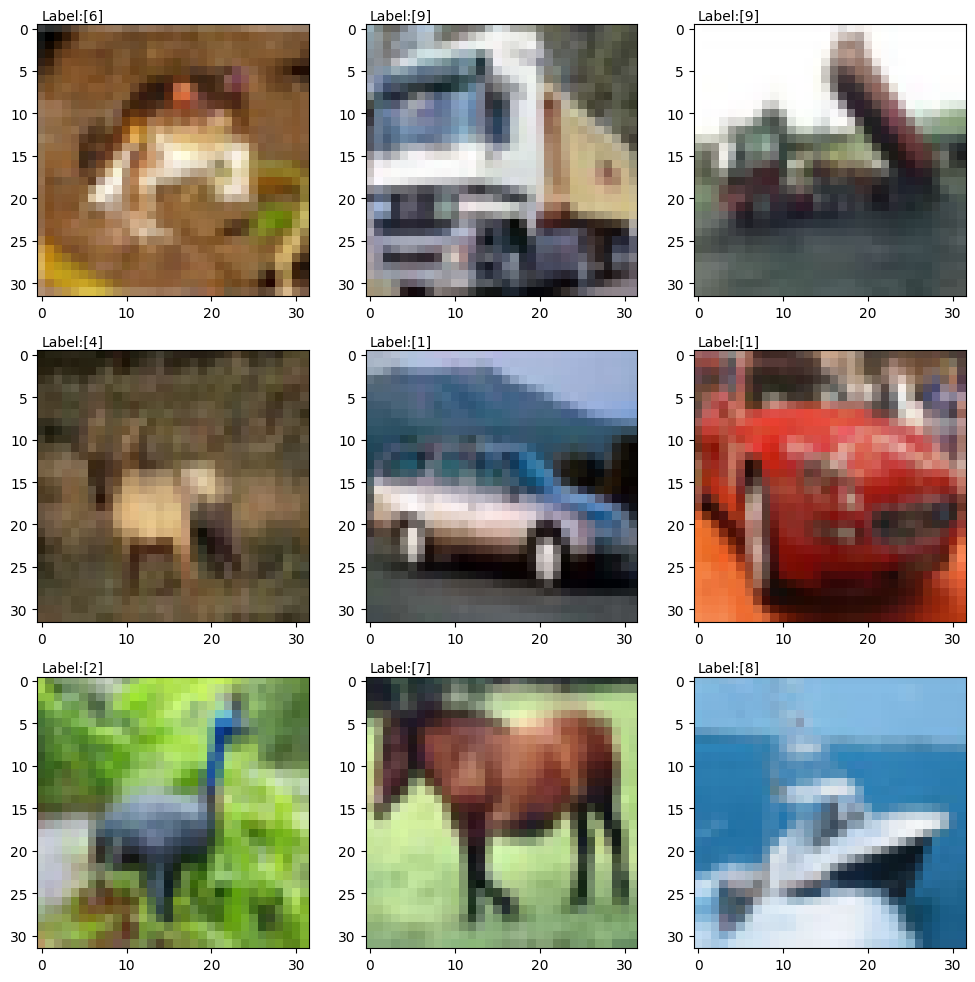

In [ ]:
# load the data and visualize
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

fig = plt.figure(figsize=(12, 12))

for i in range(3*3):
  ax1 = fig.add_subplot(3,3,i+1)
  ax1.imshow(X_train[i], cmap='gray')
  title = 'Label:'+str(y_train[i])
  ax1.text(0, -1, title, size=10)

plt.show()


### Prepare data

The pixel values are in the range of 0 to 255 for each of the (RGB) red, green and blue chanles.

It is good practice to work with normalized data. Becaouse he input values are well understand, se we can easily normalize to the range 0 to 1 by dividing each value by the maximum observation whcih is 255.

Note: The data is loaded as integers, so we must cast it to floating point values in order to perform the divison.

In [ ]:
# load data
(X_train, y_train1), (X_test, y_test1) = cifar10.load_data()
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
y_train[:3]

array([[6],
       [9],
       [9]], dtype=uint8)

The output variables are defined as ana integer from 0 to 9 for each class.

We can use a one hot encoding to transform them into a binary matrix in order to best model the classification problem. We know there are 10 ckasses for this problem, so we can expact the binary matrix to have width of 10

In [ ]:
# one hot encode outputs
y_train = to_categorical(y_train1)
y_test = to_categorical(y_test1)
num_classes = y_test.shape[1]
num_classes

10

In [ ]:
y_train[:3]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
y_train1[:3]

array([[6],
       [9],
       [9]], dtype=uint8)

### CNN Model

Two convolutional layers followed by max polling and a flattening out of the network for fully connected layers to make predicitons.
  * Convolutional input layer, 32 feature maps wiht size 3x3, a RELU activation function.
  * Dropout set to 20%.
  * Convolutional layer, 32 feature maps with a size 3x3, a rectifier activation function.
  * Max Pool layer with size 2x2.
  * Flatten layer.
  * Fully connected layer with 512 units and a rectifier activaiton function.
  * Dropout set to 50%.
  * Fully connected layer with 10 units and a softmax activation function

A logaritmic fucntion is used with the stochastic gradient descent optimization algoritihm configured with a large momentum and weight decay start with a learning rate of 0.01.

#### Build The Model

In [ ]:
# create the model
model=Sequential()
model.add(Conv2D(32, (3,3), input_shape=(32, 32, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                        

From the model summury we can see that we have 4,210,000 trainable params to fit the data into

In [ ]:
# Compile the model
epoch = 10
lrate = 0.01
decay = lrate/epoch
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#### Train the CNN model

In [ ]:
%%time
# fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 13s 7ms/step - loss: 1.7367 - accuracy: 0.3694 - val_loss: 1.4216 - val_accuracy: 0.4981
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4017 - accuracy: 0.4958 - val_loss: 1.2956 - val_accuracy: 0.5405
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2639 - accuracy: 0.5469 - val_loss: 1.1963 - val_accuracy: 0.5748
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1674 - accuracy: 0.5826 - val_loss: 1.1273 - val_accuracy: 0.5996
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0884 - accuracy: 0.6167 - val_loss: 1.0930 - val_accuracy: 0.6133
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.0318 - accuracy: 0.6335 - val_loss: 1.0302 - val_accuracy: 0.6360
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9828 - accuracy: 0.6518 - val_loss: 1.0212 - val_accur

In [ ]:
# Evaluate the trained model
scores = model.evaluate(X_test, y_test, verbose=1)
print(f'Model accuracy: {scores[1]*100:.2f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.9727 - accuracy: 0.6562
Model accuracy: 65.62


Note: The results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precison. Consider running the example a few times and compase the average outcome.

#### Evaluate the results of the CNN Model

1/1 [==============================] - 0s 149ms/step
Model Prediction 3


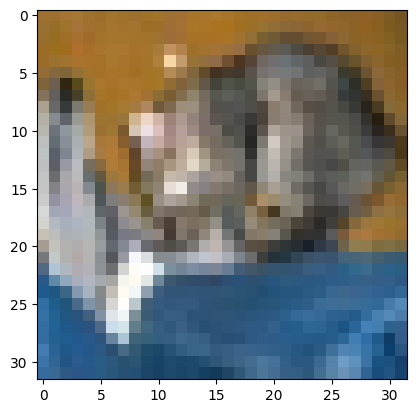

In [ ]:
plt.imshow(X_test[0])
test_sample = X_test[0]
prediction = model.predict(test_sample.reshape(1,32,32,3))

print('Model Prediction', np.argmax(prediction))

The argmax returns the index with the highest value/probability of the output vecotr

In [ ]:
prediction

array([[4.46417509e-03, 1.16315045e-04, 6.20076358e-02, 5.31890631e-01,
        5.42205386e-02, 3.23164493e-01, 8.70756991e-03, 4.03455365e-03,
        1.10169603e-02, 3.77120508e-04]], dtype=float32)

In [ ]:
prediction_hot = model.predict(X_test)
prediction_list = []

# convert the from one-hot to regular
for line in prediction_hot:
  prediction_list.append(np.argmax(line))

313/313 [==============================] - 1s 2ms/step


In [ ]:
prediction_list[:3]

[3, 1, 8]

In [ ]:
y_test[i]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

Inspect the predecitons

PREDICTION:  1


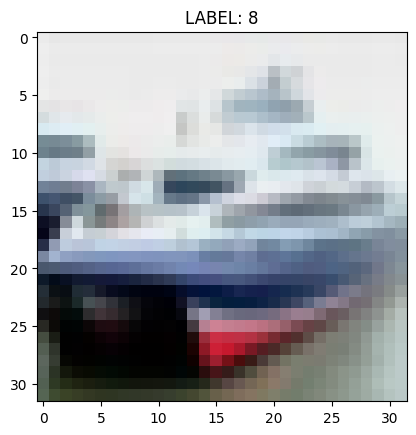

PREDICTION:  1


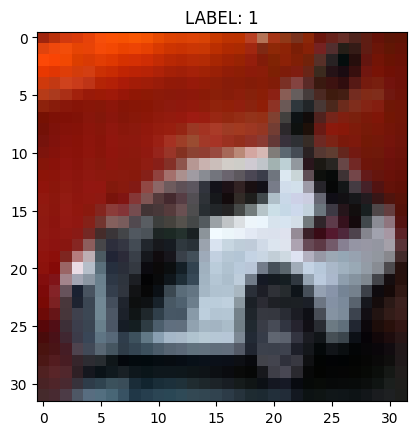

PREDICTION:  1


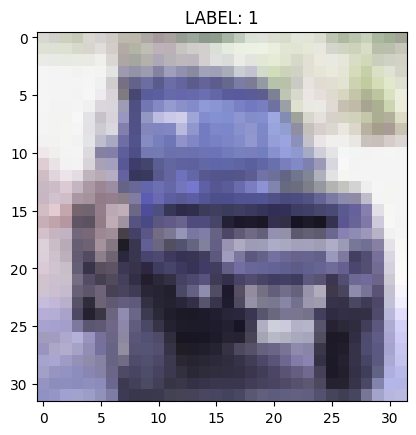

PREDICTION:  1


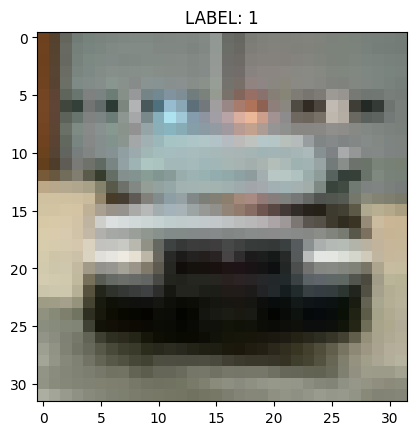

PREDICTION:  1


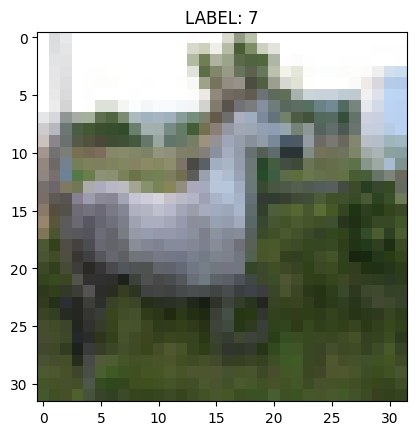

PREDICTION:  1


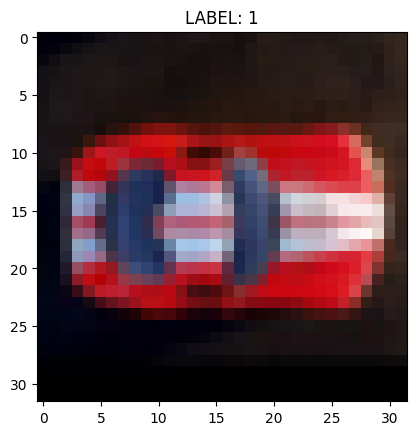

PREDICTION:  1


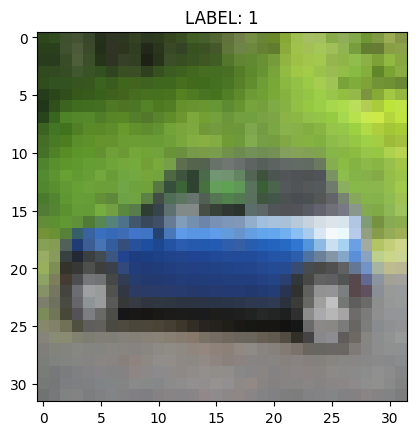

In [ ]:
label_miss = 1
prediction_miss = 1

for i in range(100):
    if np.any(prediction_list[i] == prediction_miss) and np.any(y_test[i] == label_miss):
        print('PREDICTION: ', prediction_list[i])
        plt.title('LABEL: {label}'.format(label=np.argmax(y_test[i])))
        plt.imshow(X_test[i], cmap='gray')
        plt.show()

- 0	- airplane
- 1	- automobile
- 2	- bird
- 3	- cat
- 4	- deer
- 5	- dog
- 6	- frog
- 7	- horse
- 8	- ship
- 9	- truck

**Confusion Matrix**

In [ ]:
y_test1.shape, len(prediction_list)

((10000, 1), 10000)

In [ ]:
# Confusion Matrix
# Convert prediction_list to a NumPy array
prediction_array = np.array(prediction_list)
cf_matrix = confusion_matrix(y_test1, prediction_array)
cf_matrix

array([[666,  22,  59,  26,  30,  12,  11,  20, 102,  52],
       [ 20, 776,  14,  12,   9,   2,   5,  14,  28, 120],
       [ 64,   4, 493,  59, 156,  87,  52,  56,  19,  10],
       [ 13,  12,  56, 445, 130, 210,  54,  46,  15,  19],
       [ 17,   2,  81,  52, 670,  41,  38,  83,  15,   1],
       [ 10,   5,  53, 161,  86, 582,  16,  74,   8,   5],
       [  7,   6,  46,  94, 117,  39, 659,  13,   8,  11],
       [ 10,   5,  31,  39,  88,  66,   4, 744,   4,   9],
       [ 62,  44,  16,  16,  17,   8,   6,   7, 792,  32],
       [ 25, 111,  10,  18,  10,   9,   6,  44,  32, 735]])

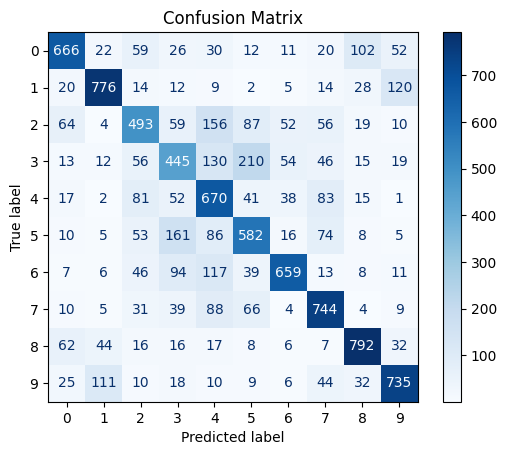

In [ ]:
# Create a Confusion Matrix Display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=np.unique(y_test1))
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Good till Here

### Hyperparameter tunning
There are two different ways to hyperparameter tunne a CNN model:

1. Using `sklearn RandomizedSearchCV`
2. Using Keras `keras_tunner RandomSearch`

For now we will use the `sklearn.model_selection.RandomizedSearchCV`

To achieve this we wll define a custom function that will create a CNN model, that will have adjustable hyperparameters.


In [ ]:
def create_model(filters=32, dropout_rate=0.25, additional_layers=0, optimizer='adam', l_rate=0.01):
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=(32, 32, 3), padding='same', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(2,2))
    for i in range(additional_layers):
        model.add(Conv2D(filters, (3,3), padding='same', activation='relu'))
        model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    if optimizer=='adam':
        optimizer=Adam(learning_rate=l_rate)
    elif optimizer=='sgd':
        optimizer = SGD(learning_rate=l_rate,decay = l_rate/epoch, momentum=0.9)
    else:
        raise ValueError('Unsupported optimizer')
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

To use scikit-learn's `RandomizedSearchCV` for hypertunning, we have to use the `KerasClassifier` wrapper to integrate Keras models into the scikit-learn ecosystem.

This will allows us to use all of the scikit-learn's utility functions for cross-validation, hyperparameter tunning, model evaluation without writing custom code for it.

# Tune using Keras Tuner

In [ ]:
pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# Define your model-building function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                            kernel_size=(3, 3),
                            activation='relu',
                            input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Set up the Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_tuner_directory',  # Specify a directory for saving logs and checkpoints
    project_name='my_hyperparameter_search'  # Specify a project name
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model and print the summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# Define your model-building function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                            kernel_size=(3, 3),
                            activation='relu',
                            input_shape=(32, 32, 3)))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Use hp.Choice for the 'additional_layers' hyperparameter
    for _ in range(hp.Choice('additional_layers', values=[1, 2])):
        model.add(layers.Conv2D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                                kernel_size=(3, 3),
                                activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(10, activation='softmax'))

    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Set up the Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_tuner_directory',
    project_name='my_hyperparameter_search'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model and print the summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


In [ ]:
from scikeras.wrappers import KerasClassifier
model = KerasClassifier(model=create_model, verbose=1)

In [ ]:
model._get_param_names

<bound method BaseWrapper._get_param_names of KerasClassifier(
	model=<function create_model at 0x7814deb76680>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)>

Define the hyperparameters to tune

In [ ]:
param_grid = {
    'filters' : [32, 64],
    'dropout_rate': [0.25, 0.50],
    'additional_layers': [0, 1],
    'optimizer': ['adam', 'sgd'],
    'epochs': [10, 20, 30, 50, 100]
}

In [ ]:
%%time
rand_srch = RandomizedSearchCV(estimator=model,
                               param_distributions=param_grid,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=2)
rand_results = rand_srch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
print(f'Best accuracy {rand_results.best_score_} - using {rand_results.best_params_}')

Best accuracy 0.3933807379294632 - using {'optimizer': 'sgd', 'epochs': 50, 'batch_size': 60}


In [ ]:
print(rand_results.)

In [ ]:
best_model = rand_results.best_estimator_
best_model.score

In [ ]:
y_preds_rand_serach = rand_results.predict(X_test)

In [ ]:
y_preds_rand_serach.shape, y_test1.shape

In [ ]:
from sklearn.metrics import accuracy_score

best_model_acc = accuracy_score(y_preds_rand_serach, y_test1)

In [ ]:
best_model_acc

# Save The Models

In [ ]:
# Save the model using model.save()
model.save("my_model.h5")

- CPU times: user 2h 34min 2s, sys: 1min 55s, total: 2h 35min 58s
- Wall time: 1h 38min 24s
- Epochs = 25
- Accuracy = Model accuracy: 70.89

In [ ]:
# Load the model using tf.keras.models.load_model()
loaded_model = tf.keras.models.load_model("my_model.h5")